In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics as m
from sklearn.preprocessing import Normalizer
import seaborn as sns

In [488]:
train = pd.read_csv('BigMartSales_Train.csv')
test = pd.read_csv('Test.csv')
train.columns.difference(test.columns)

Index(['Item_Outlet_Sales'], dtype='object')

In [489]:
test['Item_Outlet_Sales'] = np.nan
test['Source']='Test'
train['Source']='Train'

In [490]:
df = pd.concat([train,test])

In [491]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train


In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 13 columns):
Item_Identifier              14204 non-null object
Item_Weight                  11765 non-null float64
Item_Fat_Content             14204 non-null object
Item_Visibility              14204 non-null float64
Item_Type                    14204 non-null object
Item_MRP                     14204 non-null float64
Outlet_Identifier            14204 non-null object
Outlet_Establishment_Year    14204 non-null int64
Outlet_Size                  10188 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Type                  14204 non-null object
Item_Outlet_Sales            8523 non-null float64
Source                       14204 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 1.5+ MB


In [493]:
df.Item_Weight = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

In [494]:
df.Item_Weight.isna().sum()

0

In [495]:
df.Outlet_Size = df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0]))

In [496]:
df.Outlet_Size.unique()

array(['Medium', 'Small', 'High'], dtype=object)

In [497]:
import re
df['Item_code'] = df.Item_Identifier.str.extract(r'(\w\w)(\w+)',expand=True)[0]

In [498]:
df.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [499]:
df.Item_Fat_Content=df.Item_Fat_Content.map({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat','Low Fat':'Low Fat','Regular':'Regular'})
df.Item_Fat_Content.unique()

array(['Low Fat', 'Regular'], dtype=object)

In [500]:
df.loc[df.Item_Visibility==0,'Item_Visibility'] = np.nan

In [501]:
df.Item_Visibility = df.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x:x.fillna(x.median()))

In [502]:
df['Outlet_Tenure']=2019 - df.Outlet_Establishment_Year

In [503]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Source,Item_code,Outlet_Tenure
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,FD,20
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,DR,10
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,FD,20
3,FDX07,19.20,Regular,0.022919,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train,FD,21
4,NCD19,8.93,Low Fat,0.013206,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train,NC,32


In [504]:
df.Outlet_Location_Type.unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [505]:
df.loc[df['Outlet_Type'].str.startswith('Super'),'Outlet_Subtype'] = 'Supermarket'


In [506]:
df.loc[df['Outlet_Type'].str.startswith('Grocery'),'Outlet_Subtype'] = 'Grocery'

In [507]:
num_col = df.select_dtypes(exclude='object')
cat_col = df.select_dtypes(include='object')


In [508]:
cat_col1 = cat_col.drop(columns = ['Item_Identifier','Source','Outlet_Size','Outlet_Type'])

In [509]:
df['Outlet_Size'] = df['Outlet_Size'].map({'Medium':1,'Small':0,'High':2})

In [510]:
df['Outlet_Size'].unique()

array([1, 0, 2], dtype=int64)

In [511]:
dum = pd.get_dummies(df[cat_col1.columns])

In [512]:
df_prepro = pd.concat([df.drop(columns=['Outlet_Establishment_Year']),dum],axis=1)


In [513]:
modeldata = df_prepro.drop(columns=['Item_Fat_Content','Item_Type','Outlet_Subtype','Item_code','Outlet_Location_Type','Outlet_Type'])

In [514]:
modeldata.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Item_Outlet_Sales,Source,Outlet_Tenure,Item_Fat_Content_Low Fat,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Item_code_DR,Item_code_FD,Item_code_NC,Outlet_Subtype_Grocery,Outlet_Subtype_Supermarket
0,FDA15,9.30,0.016047,249.8092,OUT049,1,3735.1380,Train,20,1,...,0,1,1,0,0,0,1,0,0,1
1,DRC01,5.92,0.019278,48.2692,OUT018,1,443.4228,Train,10,0,...,0,0,0,0,1,1,0,0,0,1
2,FDN15,17.50,0.016760,141.6180,OUT049,1,2097.2700,Train,20,1,...,0,1,1,0,0,0,1,0,0,1
3,FDX07,19.20,0.022919,182.0950,OUT010,0,732.3800,Train,21,0,...,0,0,0,0,1,0,1,0,1,0
4,NCD19,8.93,0.013206,53.8614,OUT013,2,994.7052,Train,32,1,...,0,0,0,0,1,0,0,1,0,1


In [515]:
modeldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 45 columns):
Item_Identifier                    14204 non-null object
Item_Weight                        14204 non-null float64
Item_Visibility                    14204 non-null float64
Item_MRP                           14204 non-null float64
Outlet_Identifier                  14204 non-null object
Outlet_Size                        14204 non-null int64
Item_Outlet_Sales                  8523 non-null float64
Source                             14204 non-null object
Outlet_Tenure                      14204 non-null int64
Item_Fat_Content_Low Fat           14204 non-null uint8
Item_Fat_Content_Regular           14204 non-null uint8
Item_Type_Baking Goods             14204 non-null uint8
Item_Type_Breads                   14204 non-null uint8
Item_Type_Breakfast                14204 non-null uint8
Item_Type_Canned                   14204 non-null uint8
Item_Type_Dairy                    14204 n

In [516]:
train = modeldata[modeldata['Source']=='Train']
test = modeldata[modeldata['Source']=='Test']
final = test[['Item_Identifier','Outlet_Identifier']]

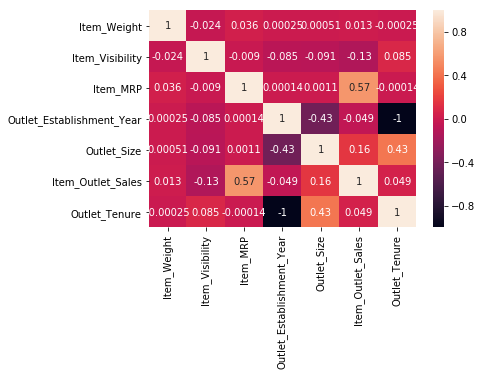

In [533]:
from sklearn.model_selection import cross_val_score as cv
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
ml = [LinearRegression(),Ridge(),Lasso(),ElasticNet()]
y = train.Item_Outlet_Sales
x = train.drop(columns=['Item_Identifier','Item_Outlet_Sales','Outlet_Identifier','Source'])
#minmax = Normalizer()
#x_minmax = minmax.fit_transform(X=x)
sns.heatmap(df.corr(),annot=True)

In [518]:
def my_scorer (est,x,y):
    yhat = est.predict(x)
    return np.sqrt(m.mean_squared_error(y,yhat))

In [519]:
model_score={}
for i in ml:
        z = str(i)[:str(i).find('(')]+'()'
        model_score[z]=np.median(cv(i,x,y,cv=10,scoring=my_scorer))
        print("{} Score is {}".format(i,model_score[z]))
      


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) Score is 1132.0724533293985
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) Score is 1132.0689105674537
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) Score is 1130.2540209959238
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False) Score is 1250.3368575573618


In [520]:
''' if 'Lasso' in str(i):
            for j in np.arange(0,1.1,0.1):
                j = round(j,2)
                k = Lasso(alpha=j)
                model_score=np.median(cv(k,x,y,cv=10,scoring=my_scorer))
                print("{} Score for alpha {} is {}".format(i,j,model_score))
        else:
            model_score=np.median(cv(i,x,y,cv=10,scoring=my_scorer))
            print("{} Score is {}".format(i,model_score))'''



' if \'Lasso\' in str(i):\n            for j in np.arange(0,1.1,0.1):\n                j = round(j,2)\n                k = Lasso(alpha=j)\n                model_score=np.median(cv(k,x,y,cv=10,scoring=my_scorer))\n                print("{} Score for alpha {} is {}".format(i,j,model_score))\n        else:\n            model_score=np.median(cv(i,x,y,cv=10,scoring=my_scorer))\n            print("{} Score is {}".format(i,model_score))'

In [521]:
best = min(model_score,key=model_score.get)

In [522]:
lm = eval(best)
#lm = LinearRegression()
lm.fit(x,y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [526]:
x_test= test.drop(columns=['Item_Identifier','Source','Outlet_Identifier','Item_Outlet_Sales'])

ytestp = lm.predict(x_test)
ytrainp = lm.predict(x)

In [527]:
final['Item_Outlet_Sales'] = ytestp
final.head()

C:\Users\sundara kesavan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1822.442979
1,FDW14,OUT017,1523.102404
2,NCN55,OUT010,1894.843147
3,FDQ58,OUT017,2562.931867
4,FDY38,OUT027,5155.835465


In [528]:
 np.sqrt(m.mean_squared_error(y,ytrainp))


1127.2850177257721

In [529]:
final.to_csv('Final.csv',index=False)